In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def read_tsp_coords(tsp_path):
    coords = []
    with open(tsp_path, 'r') as f:
        start = False
        for line in f:
            if 'NODE_COORD_SECTION' in line:
                start = True
                continue
            if 'EOF' in line or not start:
                continue
            parts = line.strip().split()
            if len(parts) == 3:
                _, x, y = parts
                coords.append((float(x), float(y)))
    return coords

def read_tour(tour_path):
    tour = []
    with open(tour_path, 'r') as f:
        start = False
        for line in f:
            if 'TOUR_SECTION' in line:
                start = True
                continue
            if not start:
                continue
            idx = line.strip()
            if idx == '-1' or idx == '':
                break
            tour.append(int(idx) - 1)  # 0-based index
    return tour

def plot_tour(coords, tour, title='TSP Tour', markersize=5, linewidth=0.5):
    xs = [coords[i][0] for i in tour] + [coords[tour[0]][0]]
    ys = [coords[i][1] for i in tour] + [coords[tour[0]][1]]
    plt.figure(figsize=(8, 6))
    plt.plot(xs, ys, marker='.', markersize=markersize, linestyle='-', linewidth=linewidth, color='black')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

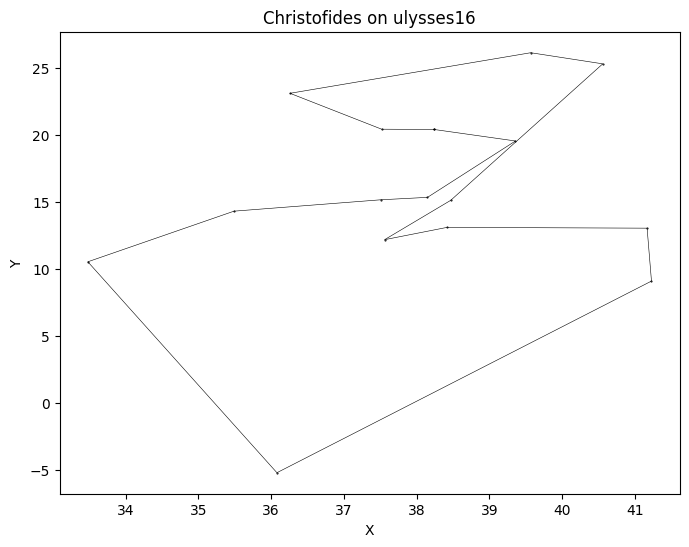

In [36]:
algorithm = 'christofides'
# algorithm = 'heldkarp'
# algorithm = 'mst2approx'
dataset = 'ulysses16'
coords = read_tsp_coords(f'../data/{dataset}.tsp')
tour = read_tour(f'../result/{algorithm}_{dataset}.tour')
plot_tour(coords, tour, f'{algorithm.capitalize()} on {dataset}', markersize=1, linewidth=0.4)

In [49]:
def plot_hylos_tour(dataset, markersize=5, linewidth=0.5):
    # Read coordinates and tour
    coords = read_tsp_coords(f'../data/{dataset}.tsp')
    tour = read_tour(f'../result/hylos_{dataset}.tour')
    
    # Read clusters
    clusters = []
    centroids = []
    shared_nodes = set()
    with open(f'../result/hylos_{dataset}_clusters.txt', 'r') as f:
        current_cluster = []
        for line in f:
            if line.startswith('Cluster'):
                if current_cluster:
                    clusters.append(current_cluster)
                current_cluster = []
            elif line.startswith('Centroid'):
                # Parse centroid coordinates from the line "Centroid: (x, y)"
                coords_str = line.split('(')[1].split(')')[0]
                x, y = map(float, coords_str.split(','))
                centroids.append((x, y))
            elif line.startswith('Cities:'):
                # Parse cities, skipping the "Cities:" prefix
                nodes = [int(x)-1 for x in line[7:].strip().split()]  # Convert to 0-based index
                current_cluster.extend(nodes)
            else:
                nodes = [int(x)-1 for x in line.strip().split()]  # Convert to 0-based index
                current_cluster.extend(nodes)
        if current_cluster:
            clusters.append(current_cluster)
    
    # Find shared nodes (nodes that appear in multiple clusters)
    node_count = {}
    for cluster in clusters:
        for node in cluster:
            node_count[node] = node_count.get(node, 0) + 1
    shared_nodes = {node for node, count in node_count.items() if count > 1}
    
    # Plot tour with different colors for each cluster
    plt.figure(figsize=(8, 6))
    
    # Generate distinct colors for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))
    
    # Create mapping from node to cluster index
    node_to_cluster = {}
    for cluster_idx, cluster in enumerate(clusters):
        for node in cluster:
            if node not in shared_nodes:  # Only map non-shared nodes
                node_to_cluster[node] = cluster_idx
    
    # Plot edges with cluster colors
    for i in range(len(tour)):
        start = tour[i]
        end = tour[(i + 1) % len(tour)]
        
        # If both nodes belong to same cluster or one is shared and one belongs to a cluster, use cluster color
        if start in node_to_cluster and end in node_to_cluster:
            # Both nodes in same cluster
            if node_to_cluster[start] == node_to_cluster[end]:
                color = colors[node_to_cluster[start]]
            else:
                color = 'black'
        elif start in node_to_cluster:
            # Start node in cluster, end node is shared
            color = colors[node_to_cluster[start]]
        elif end in node_to_cluster:
            # End node in cluster, start node is shared  
            color = colors[node_to_cluster[end]]
        else:
            # Both nodes are shared
            color = 'black'
            
        plt.plot([coords[start][0], coords[end][0]], 
                 [coords[start][1], coords[end][1]], 
                 linestyle='-', linewidth=linewidth, color=color)
    
    # Plot nodes for each cluster
    for cluster_idx, cluster in enumerate(clusters):
        cluster_nodes = set(cluster) - shared_nodes
        xs = [coords[i][0] for i in cluster_nodes]
        ys = [coords[i][1] for i in cluster_nodes]
        plt.scatter(xs, ys, color=colors[cluster_idx], s=markersize**2)
        
        # Add node labels for cluster nodes
        # for node in cluster_nodes:
        #     plt.annotate(str(node+1), (coords[node][0], coords[node][1]), 
        #                 xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Plot shared nodes with larger black markers
    xs = [coords[i][0] for i in shared_nodes]
    ys = [coords[i][1] for i in shared_nodes]
    plt.scatter(xs, ys, color='black', s=(markersize*2)**2)
    
    # Add node labels for shared nodes
    # for node in shared_nodes:
    #     plt.annotate(str(node+1), (coords[node][0], coords[node][1]), 
    #                 xytext=(5, 5), textcoords='offset points', fontsize=8)

    # Plot centroids and connect them with yellow lines
    centroid_xs = [c[0] for c in centroids]
    centroid_ys = [c[1] for c in centroids]

    # Connect centroids in the cluster order
    for i in range(len(centroids)):
        start = i
        end = (i + 1) % len(centroids)
        plt.plot([centroids[start][0], centroids[end][0]], 
                [centroids[start][1], centroids[end][1]], 
                linestyle='-', linewidth=10, color='black', alpha=0.1)

    # Plot centroids with their cluster colors
    # for i in range(len(centroids)):
    #     plt.scatter(centroid_xs[i], centroid_ys[i], color=colors[i], s=markersize*100, alpha=0.1)
    
    plt.title(f'Hylos Clusters on {dataset}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

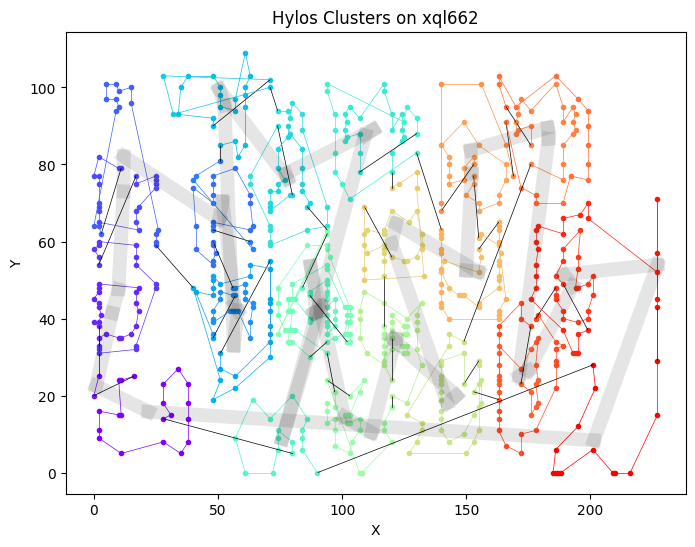

In [50]:
algorithm = 'hylos'
dataset = 'xql662'
plot_hylos_tour(dataset, markersize=3, linewidth=0.5)